```{image} ../images/era-temp2.png
:width: 100%
:align: center
```

# Explorando ERA5 con datos en formato Zarr
---

## 🧭 Introducción

En este cuadernillo aprenderás a trabajar con datos climáticos globales provenientes del producto de reanálisis **ERA5**, disponible públicamente en Google Cloud en formato **Zarr**. Utilizaremos `xarray`, `fsspec` y `dask` para explorar y visualizar datos de temperatura sin necesidad de descargarlos completamente.


## 📚 ¿Qué vas a aprender?

✔ Qué es ERA5 y por qué es útil para estudios climáticos  
✔ Cómo acceder a datos de ERA5 en formato Zarr desde la nube  
✔ Cómo explorar la estructura jerárquica de un almacén Zarr  
✔ Técnicas para filtrar, visualizar y analizar campos de temperatura  
✔ Cómo extraer información espacial y temporal relevante  
✔ Qué es el *lazy loading* y cómo permite analizar datos sin cargarlos completamente en memoria  
✔ Cómo usar *data streaming* para cargar solo los datos necesarios de forma eficiente  


## ✅ Requisitos Previos
```{list-table}
:header-rows: 1
* - Concepto
  - Importancia
  - Enlace sugerido
* - [Fundamentos de Python](../1.fundamentos/1.1.Fundamentos-python.ipynb)
  - Necesario
  - Fundamentos del lenguaje y estructuras básicas
* - [Xarray](../1.fundamentos/1.4.Introduccion-Xarray.ipynb)
  - Necesario
  - Manipulación de arreglos y datos multidimensionales
* - [Radar meteorológico](../1.fundamentos/1.5.Introduccion-Radar.ipynb)
  - Necesario
  - Conceptos básicos de adquisición y estructura de datos de radar
* - [Zarr y flujos de trabajo FAIR](https://zarr.dev/)
  - Útil
  - Concepto de almacenamiento en la nube y acceso eficiente a grandes volúmenes de datos
* - [Artículo sobre QVPs](https://doi.org/10.1175/JTECH-D-15-0020.1)
  - Útil
  - Fundamento teórico sobre Perfiles Cuasi-Verticales (Ryzhkov et al., 2016)



⏱️ Tiempo estimado: 30 minutos  
✍️ Formato: Interactivo. Ejecuta y modifica el código en cada celda.

---

## 1. 🌍 Introducción a ERA5

ERA5 es la quinta generación de reanálisis atmosférico producida por el **Centro Europeo de Predicción Meteorológica a Mediano Plazo (ECMWF)**. Este conjunto de datos combina observaciones históricas con modelos numéricos para generar una reconstrucción coherente del estado de la atmósfera en el pasado reciente.

Los reanálisis son fundamentales para estudios climáticos, ya que proporcionan información espacial y temporalmente continua, incluso en regiones donde las observaciones directas son escasas.

### 1.1. 📌 ¿Qué es un Reanálisis?

Un **reanálisis** es una reconstrucción científica del clima pasado basada en:

- 🌐 **Observaciones históricas**:
  - Estaciones de superficie
  - Globos meteorológicos
  - Satélites
  - Buques, boyas y aviones

- 🧠 **Modelos numéricos**:
  - Ecuaciones físicas modernas de la atmósfera
  - Técnicas de asimilación de datos
  - Poder computacional avanzado

### 1.2. 📎 Características clave de ERA5

- ✅ Cobertura global: datos para toda la Tierra
- ⏱️ Periodo temporal: desde 1950 hasta el presente (con datos horarios desde 1979)
- 🌐 Resolución espacial: 0.25° (~31 km)
- 📈 Más de 240 variables disponibles (temperatura, viento, precipitación, etc.)
- ⚙️ Datos consistentes gracias a la asimilación de observaciones

💡 **Nota:** En este cuadernillo trabajaremos directamente con los datos de ERA5 almacenados en formato Zarr en Google Cloud, lo que permite explorar grandes volúmenes de información sin necesidad de descargarlos completamente.


## 2. ☁️ Acceso a datos ERA5 en formato Zarr

El conjunto de datos ERA5 se encuentra disponible públicamente en la nube gracias al proyecto [ARCO-ERA5](https://registry.opendata.aws/ecmwf-era5/). Estos datos se almacenan utilizando el formato **Zarr**, que permite el acceso remoto y eficiente a gran escala, ideal para su análisis con herramientas como `xarray` y `fsspec`.

Este enfoque permite consultar partes específicas del conjunto de datos sin necesidad de descargar archivos completos, aprovechando el concepto de *data streaming* o acceso bajo demanda.

### 2.1. 🧭 Exploración inicial del repositorio

Podemos inspeccionar el contenido del bucket público de Google Cloud Storage utilizando `fsspec`:


In [1]:
import fsspec

fs = fsspec.filesystem('gcs', token='anon')
store_path = 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'

# Mostrar archivos contenidos en el dataset
files = fs.ls(store_path)
for f in files[:4]:
    print(f)

gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zattrs
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zgroup
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata
gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_u_component_of_wind


### 2.2. 🔬 Metadatos del dataset

El archivo `.zmetadata` contiene información general sobre el conjunto de datos. Podemos consultarlo con el siguiente código:


In [2]:
import json

path = f"{store_path}/.zmetadata"
with fs.open(path, 'r') as f:
    zmetadata = json.load(f)

zmetadata["metadata"][".zattrs"]

{'valid_time_start': '1940-01-01',
 'last_updated': '2025-06-21 02:00:39.594246+00:00',
 'valid_time_stop': '2025-02-28',
 'valid_time_stop_era5t': '2025-06-15'}

Esto nos devuelve información global del conjunto de datos, como el rango de fechas, última actualización o propiedades comunes a todas las variables.

````{figure} https://zarr-specs.readthedocs.io/en/latest/_images/terminology-hierarchy.excalidraw.png
:name: fig-zarr-hierarchy
:alt: Zarr Hierarchy Diagram
:width: 60%
:align: center

Esquema jerárquico de un almacén Zarr. Cada variable se representa como un conjunto de bloques (chunks) distribuidos, acompañados de sus respectivos metadatos.

```{hint}
💡 **Nota importante**

El archivo `.zmetadata` contiene información sobre todas las variables del conjunto de datos. Si imprimes todo su contenido, obtendrás una salida extensa con más de **250 variables** disponibles en el dataset. Para explorar de forma más manejable, puedes inspeccionar primero la clave `"metadata"` o filtrar por nombres específicos de variables.

Consultemos algunos detalles sobre la estructura de una variable específica, como `2m_temperature`:


In [3]:
zmetadata["metadata"]["2m_temperature/.zarray"]

{'chunks': [1, 721, 1440],
 'compressor': {'blocksize': 0,
  'clevel': 5,
  'cname': 'lz4',
  'id': 'blosc',
  'shuffle': 1},
 'dtype': '<f4',
 'fill_value': 'NaN',
 'filters': None,
 'order': 'C',
 'shape': [1323648, 721, 1440],
 'zarr_format': 2}

### 📄 ¿Qué contiene el archivo `.zarray`?

El archivo `.zarray` describe cómo está estructurada una variable dentro de un dataset Zarr. Incluye información sobre:

- Las dimensiones del arreglo (`shape`)
- El tipo de dato utilizado (`dtype`)
- El tamaño de los bloques o *chunks* (`chunks`)
- El esquema de compresión aplicado (`compressor`)
- El valor para datos faltantes (`fill_value`)
- El orden de almacenamiento en memoria (`order`)
- La versión del formato Zarr utilizada (`zarr_format`)

Este archivo es esencial para que librerías como `xarray` puedan leer solo partes del arreglo bajo demanda, lo cual habilita estrategias como *lazy loading* y *data streaming*.


## 3. 📂 Apertura del archivo ERA5 con `xarray`

Para acceder al conjunto de datos ERA5 en formato **Zarr** almacenado en Google Cloud, podemos utilizar la función [`xarray.open_zarr`](https://docs.xarray.dev/en/stable/generated/xarray.open_zarr.html), junto con `fsspec`.

Esta función permite acceder de forma eficiente a grandes volúmenes de datos climáticos sin necesidad de descargarlos por completo a disco, utilizando la arquitectura de *data streaming*.

### 3.1. 🧠 Apertura del dataset


In [4]:
import xarray as xr

In [5]:
%%time
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={},  # Activamos el acceso en streaming
    consolidated=True,
    storage_options=dict(token='anon')  # Acceso anónimo
)

CPU times: user 1min 31s, sys: 4.91 s, total: 1min 36s
Wall time: 1min 38s


El conjunto de datos se ha abierto correctamente utilizando acceso anónimo y carga perezosa (lazy loading) gracias al formato `zarr`

In [6]:
display(ds)

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 11MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    zero_degree_level                                                (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    last_updated:           2025-06-21 02:00:39.594246+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-02-28
    valid_time_stop_era5t:  2025-06-15

## 3.2. 📂 Exploración de variables disponibles

Después de cargar el dataset ERA5 con `xarray`, es útil inspeccionar qué variables contiene y cómo están organizadas.


In [7]:
# Mostrar las variables contenidas en el dataset
list(ds.data_vars)[:10]

['100m_u_component_of_wind',
 '100m_v_component_of_wind',
 '10m_u_component_of_neutral_wind',
 '10m_u_component_of_wind',
 '10m_v_component_of_neutral_wind',
 '10m_v_component_of_wind',
 '10m_wind_gust_since_previous_post_processing',
 '2m_dewpoint_temperature',
 '2m_temperature',
 'air_density_over_the_oceans']

```{hint}
El conjunto de datos contiene más de 250 variables climáticas como temperatura, viento, humedad, presión, entre otras. Aquí mostramos solo las primeras 10.
```

### 3.3. 💾 Tamaño del dataset

Una vez abierto el dataset, es útil calcular su tamaño total estimado en memoria. Esto nos ayuda a dimensionar los recursos necesarios para su análisis.


In [8]:
# Tamaño total del dataset en PiB (pebibytes)
total_bytes = ds.nbytes
print(f"Dataset size: {total_bytes / 1024**5:.2f} PiB")

Dataset size: 3.27 PiB


El objeto `ds` contiene:

- ➕ Más de 250 variables meteorológicas
- 📐 Dimensiones: `time`, `latitude`, `longitude`
- 🌍 Coordenadas: latitudes (-90 a 90), longitudes (0 a 360)
- 📝 Atributos globales y metadatos del sistema

```{note}
Usa `ds.data_vars` para listar variables y `ds.attrs` para ver metadatos generales.

## 4. 🧪 Extracción y análisis de datos

Una vez cargado el conjunto de datos ERA5, podemos realizar operaciones de filtrado temporal y espacial para enfocarnos en regiones o periodos específicos. Esto permite trabajar con subconjuntos manejables de datos y facilita el análisis exploratorio.

### 4.1. 🕒 Selección temporal


In [9]:
# Inspeccionar el rango de fechas disponibles
print(f"Time range: {ds.time.min().values} to {ds.time.max().values}")

Time range: 1900-01-01T00:00:00.000000000 to 2050-12-31T23:00:00.000000000


In [10]:
# Calcular el número de pasos de tiempo y su resolución
import numpy as np

time_res_ns = int(ds.time.diff('time')[0].values)  # nanosegundos
time_res_hours = time_res_ns / (1e9 * 3600)

total_ns = int(ds.time[-1].values - ds.time[0].values)
total_days = total_ns / (1e9 * 3600 * 24)
total_years = total_days / 365.25
n_steps = len(ds.time)

print(f"{total_days:,.0f} días")
print(f"{total_years:,.0f} años")
print(f"Número total de pasos de tiempo: {n_steps:,}")
print(f"Resolución temporal: {time_res_hours:.1f} horas")

55,152 días
151 años
Número total de pasos de tiempo: 1,323,648
Resolución temporal: 1.0 horas


```{note}
ERA5 proporciona datos con resolución horaria desde 1940 hasta el presente. Este amplio rango temporal permite realizar análisis climáticos a largo plazo.
```

### 4.2. 🌎 Selección espacial: subregión de Colombia

En ERA5, las coordenadas de longitud están expresadas de 0° a 360° (en lugar del formato estándar -180° a 180°), y la latitud va de 90° (norte) a -90° (sur).

Para seleccionar la región de Colombia, usamos los siguientes límites aproximados:

- **Longitud**: 275° a 300° (equivalente a -85° a -60°)
- **Latitud**: 14° a -3°

In [11]:
# Extraer la variable de temperatura a 2 metros (en Kelvin)
t2m = ds['2m_temperature']

In [12]:
t2m_col = t2m.sel(
    longitude=slice(275, 300),  # de -85° a -60°
    latitude=slice(14, -3)      # de norte a sur
)


In [13]:
display(t2m_col)

<xarray.DataArray '2m_temperature' (time: 1323648, latitude: 69, longitude: 101)> Size: 37GB
dask.array<getitem, shape=(1323648, 69, 101), dtype=float32, chunksize=(1, 69, 101), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 276B 14.0 13.75 13.5 13.25 ... -2.5 -2.75 -3.0
  * longitude  (longitude) float32 404B 275.0 275.2 275.5 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

```{tip}
Puedes adaptar los límites de latitud y longitud para estudiar otras regiones geográficas de interés.
```

## 5. 📊 Visualización de datos con carga progresiva (`data streaming`)

El dataset de ERA5 es extremadamente grande, por lo que es fundamental utilizar estrategias de *data streaming* y *lazy loading* para visualizar únicamente los datos necesarios en cada momento. Estas técnicas permiten representar variables sin necesidad de cargar todo el conjunto de datos en memoria.


### 5.1. 🖼️ Visualización de temperatura en un instante de tiempo

En esta subsección exploramos cómo representar un campo de temperatura en un instante específico del tiempo. Esta técnica permite una inspección rápida de patrones espaciales sin necesidad de procesar todo el conjunto de datos.


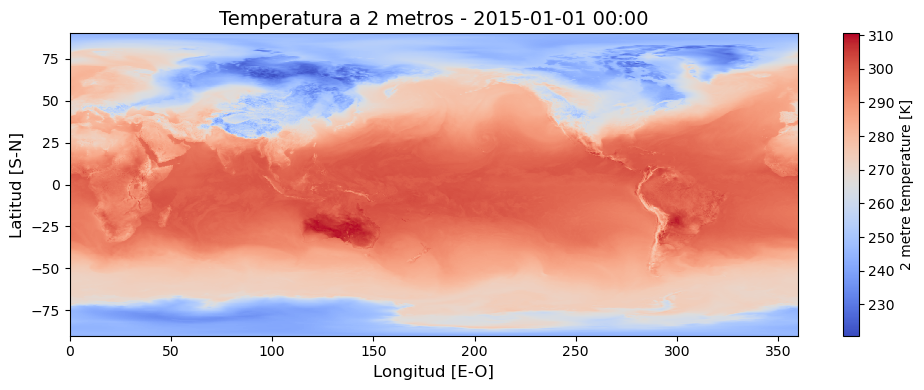

In [22]:
import matplotlib.pyplot as plt

# Seleccionar un instante específico
instant = "2015-01-01 00:00"
fig, ax = plt.subplots(figsize=(10, 4))

# Graficar temperatura en Kelvin
t2m.sel(time=instant).plot(ax=ax, cmap="coolwarm")

# Embellecer la figura
ax.set_title(f"Temperatura a 2 metros - {instant}", fontsize=14)
ax.set_xlabel("Longitud [E-O]", fontsize=12)
ax.set_ylabel("Latitud [S-N]", fontsize=12)
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("../images/era-temp2.png", dpi=150, bbox_inches='tight')
plt.show()

```{note}
La visualización accede únicamente a los datos del tiempo y la región seleccionados. Esta eficiencia se logra gracias a la combinación de `xarray`, `Zarr` y `Dask` (si está disponible).
```

## 5.2. 🌡️ Temperatura diaria para Colombia — 19 de junio de 2024

Vamos a calcular y visualizar el campo de temperatura a 2 metros sobre el suelo para la región de **Colombia** en la fecha **2025-06-19**. Primero convertimos la temperatura de **Kelvin a grados Celsius**.

La selección espacial y temporal se realiza con `xarray`, pero **aún no se han traído datos a memoria**. Esto es posible gracias al *lazy loading* de `Dask`.


In [36]:
# Seleccionamos una fecha específica y convertimos de Kelvin a °C
col_temp_2024 = t2m_col.sel(time="2024-06-14") - 273.15

In [37]:
# Mostramos la representación Dask (no se ha cargado a memoria todavía)
display(col_temp_2025)

<xarray.DataArray '2m_temperature' (time: 24, latitude: 69, longitude: 101)> Size: 669kB
dask.array<sub, shape=(24, 69, 101), dtype=float32, chunksize=(1, 69, 101), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 276B 14.0 13.75 13.5 13.25 ... -2.5 -2.75 -3.0
  * longitude  (longitude) float32 404B 275.0 275.2 275.5 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 192B 2024-06-18 ... 2024-06-18T23:00:00

Como se puede ver, aún no se han traído los datos reales: el objeto sigue siendo un *Dask array* pendiente de evaluación.

```{note}
La variable contiene 24 estampas temporales correspondientes a cada hora del día **19 de junio de 2024**, sobre la región de Colombia.
```

### 🖼️ Visualización de temperatura promedio del día

Calculamos el promedio diario sobre las 24 horas y luego graficamos el resultado. En esta etapa, se realiza *data fetching* y los datos son traídos desde la nube.

In [38]:
# Promedio temporal (aún no se evalúa)
mean_temp_2024 = col_temp_2024.mean("time")

In [39]:
display(mean_temp_2024)

<xarray.DataArray '2m_temperature' (latitude: 69, longitude: 101)> Size: 28kB
dask.array<mean_agg-aggregate, shape=(69, 101), dtype=float32, chunksize=(69, 101), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 276B 14.0 13.75 13.5 13.25 ... -2.5 -2.75 -3.0
  * longitude  (longitude) float32 404B 275.0 275.2 275.5 ... 299.5 299.8 300.0

```{note}
Después de aplicar `.mean("time")`, la dimensión **temporal desaparece**, ya que ahora estamos trabajando con un solo campo promedio mensual. Por ejemplo, en lugar de 24 estampas horarias típicas para un día, obtenemos **solo una matriz** con los valores promedio de junio de 2025.
```

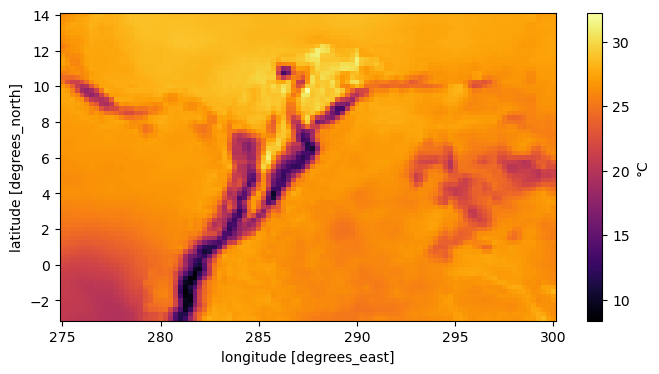

In [40]:
# Visualizamos el promedio mensual
mean_temp_2024.plot(
    cmap="inferno",
    figsize=(8, 4),
    cbar_kwargs={"label": "°C"},
)

```{hint}
Este paso activa la lectura de datos desde el repositorio remoto (data streaming). Solo se traen los bloques necesarios para completar esta visualización específica.
```

## 6. ⚙️ Ventajas del Lazy Loading en ERA5

El acceso a datos en formato **Zarr** permite utilizar estrategias de **lazy loading** y **data streaming**, lo cual significa que los datos no se cargan completamente en memoria, sino solo cuando se necesitan. Esto es especialmente útil al trabajar con conjuntos de datos climáticos como **ERA5**, cuyo tamaño completo puede superar los **3.27 Petabytes (PB)**.

Con `xarray`, operaciones como `.sel()`, `.isel()` o incluso `.mean()` generan grafos de cómputo que se ejecutan solo cuando se llama explícitamente a `.compute()` o `.plot()` — optimizando el uso de recursos computacionales.

::::{admonition} ⚠️ **¡Cuidado!** No operes sobre el dataset completo
:class: warning

El conjunto de datos `ds` representa aproximadamente **3.27 PB de información**. Ejecutar operaciones directamente sobre este objeto **sin subsetting** (como `.plot()`, `.values`, `.to_numpy()`, `.mean()`, etc.) provocará una descarga masiva de datos que probablemente:

- 📉 saturará tu memoria RAM  
- 🧨 colapsará tu sesión de Jupyter  
- 🚫 sobrecargará el backend de cómputo

::::{admonition} ✅ Mejores prácticas
- Usa `.sel()` o `.isel()` para seleccionar una subregión (espacial o temporal)
- Aplica `.compute()` o `.load()` **solo después** de hacer el subsetting
- ❌ Evita `.plot()` o acceder a `.values` sobre el dataset completo `ds`
::::


```{note}
Siempre verifica las dimensiones y el tamaño del bloque antes de realizar operaciones computacionalmente costosas.
```


---

## ✅ Conclusiones

En este cuadernillo aprendimos a acceder y explorar el conjunto de datos de reanálisis **ERA5**, almacenado en formato **Zarr** y disponible públicamente en la nube de **Google Cloud**. Algunos puntos clave:

✔️ Comprendimos qué es un reanálisis y por qué ERA5 es fundamental para estudios climáticos  
✔️ Accedimos al dataset completo sin necesidad de descarga local masiva, utilizando `xarray` y `fsspec`  
✔️ Realizamos selección temporal y espacial sobre una región específica (Colombia: latitud 14°N a -3°S, longitud 275°E a 300°E)  
✔️ Visualizamos campos de temperatura y calculamos promedios diarios  
✔️ Aplicamos principios de *lazy loading* y *data streaming* para trabajar eficientemente con grandes volúmenes de datos

## 📚 Recursos y referencias

- [ERA5 en ECMWF](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)  
- [Google Cloud Public Dataset - ARCO ERA5](https://console.cloud.google.com/marketplace/product/ecmwf/era5)  
- [Zarr documentation](https://zarr.readthedocs.io/en/stable/)  
- [xarray documentation](https://docs.xarray.dev/en/stable/)  
- [fsspec documentation](https://filesystem-spec.readthedocs.io/en/latest/)  
- [Project Pythia Foundations](https://foundations.projectpythia.org/)  